In [1]:
import sys
# import pyqtgraph as pg
import cnmodel
from cnmodel.protocols import IVCurve, VCCurve

--No graphics will be displayed.
[38036] Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[38036] Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
[38036] NumExpr defaulting to 16 threads.


In [2]:
temperature = 34.
cell = cnmodel.cells.Pyramidal.create(model='POK',
                                      ttx=False, nach=None)
cell.set_temperature(float(temperature))

In [20]:
v0 = cell.find_i0(showinfo=True)
iv = IVCurve()
iv.run({'pulse': [(0, 0.05, 0.01)]},
       cell, durs=[400, 500, 400],
       sites=None, reppulse=None, temp=float(temperature))
# result = iv.input_resistance_tau()
# print('    From IV: Rin = {:7.1f}  Tau = {:7.1f}  Vm = {:7.1f}'.format(result['slope'], result['tau'], result['intercept']))
# iv.show(cell=cell)

# if sys.flags.interactive == 0:  # keeps application alive for display of data
#     pg.QtGui.QApplication.exec_()


  [soma] find_i0  Species: rat  cell type: pyramidal  Temp   32.0
    *** found V0 = -62.496552
    *** and cell has mechanisms:  ['napyr', 'kdpyr', 'kif', 'kis', 'ihpyr', 'leak']


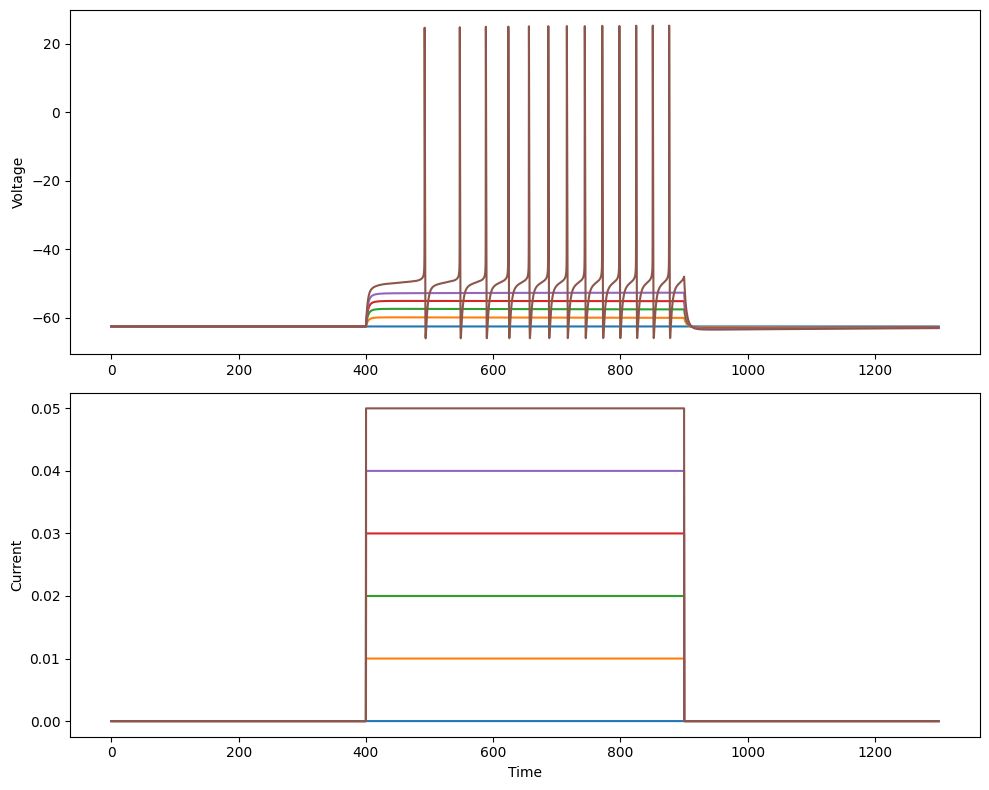

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,1, figsize=(10,8))
axs.ravel()

for i, voltage_trace in enumerate(iv.voltage_traces):

    axs[0].plot(iv.time_values, voltage_trace)
    axs[1].plot(iv.time_values, iv.current_traces[i])

# plt.plot(iv.voltage_traces[0], iv.current_traces[0])
axs[0].set_ylabel('Voltage')
axs[1].set_ylabel('Current')
axs[1].set_xlabel('Time')

fig.tight_layout()

In [ ]:

# import cochlea.stats